# **Medical Informatics Report 1**
### **Implementation of a Tomography Simulator**
**Author:** Marcelina Gancewska  
**Student ID:** 156024  
**Language:** Python (Jupyter Notebook)  
**Emmiting Mode:** Cone (stożkowy)
**Mode of radiation absorbtion:** Additive


First I import all required libraries

In [1]:
# General
import numpy as np
import matplotlib.pyplot as plt
# For the GUI
import ipywidgets as widgets
from IPython.display import display, clear_output
# For image processing 
from PIL import Image
import skimage as ski  
# For working with files
import io
# For filtering
import cv2 
# For MSE
from sklearn.metrics import mean_squared_error
# For Dicom handling
import pydicom
from pydicom.data import get_testdata_files
import datetime


Then I defined some image processing convenience functions

In [ ]:
def load_image(filename):
    image = ski.io.imread(filename)
    image = image.astype(np.float64)
    if len(image.shape) == 3:
        image = ski.color.rgb2gray(image)
    image /= np.max(image)
    return image

def save_image(image, filename):
    data = (image * 255).astype(np.uint8)
    ski.io.imsave(filename, data)

def show_image(image, title=None):
    if title is not None:
        plt.title(title)
    plt.imshow(image, cmap='gray')
    plt.show()

Bresenham algorithm for path tracing

In [3]:
def bresenham_line_nd(start, end):
    # Parse to arrays of int
    start = np.array(start, dtype=int)
    end = np.array(end, dtype=int)
    
    delta = end - start
    # Dimensions
    num_dims = len(delta)
    abs_delta = np.abs(delta)
    max_dist = np.max(abs_delta)
    
    coords = np.zeros((num_dims, max_dist + 1), dtype=int)
    
    for dim in range(num_dims):
        # Equally spaced values
        coords[dim] = np.linspace(start[dim], end[dim], max_dist + 1, dtype=int)
    
    return coords


Below I defined the most crucial element of the project: radom transform and reverse radom transform

In [4]:
# radon_transform parameters:
# processed image, number of detetors, number of angles to scan, total angle covered
# Cone modlel is used 
def radon_transform(image, num_detectors=180, num_scans=180, fov_degrees=180):
    center = np.array(image.shape) // 2 
    radius = np.sqrt(2) * max(center)
    radon_image = np.zeros((num_scans, num_detectors), dtype=image.dtype) # initialize empty
    global intermediate_steps
    intermediate_steps=[]
    

    # Convert field of view (FOV) from degrees to radians
    fov_radians = np.deg2rad(fov_degrees)
    scan_angles = np.linspace(0, 2 * np.pi, num_scans, endpoint=False) # generate angles to scan on 
    detector_spacing = fov_radians / (num_detectors - 1) # gap between emitters

    for scan_index, scan_angle in enumerate(scan_angles): # for each angle
        emitter_pos = center + radius * np.array([np.cos(scan_angle), np.sin(scan_angle)]) # calcu. emitter position
        
        for detector_index in range(num_detectors):
            detector_angle = scan_angle + np.pi - (fov_radians / 2) + detector_index * detector_spacing
            detector_pos = center + radius * np.array([np.cos(detector_angle), np.sin(detector_angle)])
            
            # Generate pixel line from emitter to detector (using ski)
            y_coords, x_coords = bresenham_line_nd(emitter_pos, detector_pos)
            # Keep only the coordinates within the image
            valid = (
                (0 <= x_coords) & (x_coords < image.shape[1]) &
                (0 <= y_coords) & (y_coords < image.shape[0])
            )
            valid_coords = (y_coords[valid], x_coords[valid])
            
            # Compute the average value along the line
            if len(valid_coords[0]) > 0: # if any pixels
                radon_image[scan_index, detector_index] = np.mean(image[valid_coords]) # average intensity of the line
            else:
                radon_image[scan_index, detector_index] = 0
        intermediate_steps.append(radon_image.copy())

    return radon_image

In [5]:
# inverse_radon_transform parameters:
# processed image (sinnogram), initial shape of the image, total angle covered
# Cone modlel is used 
def inverse_radon_transform(sinogram, shape, detecting_angle=180):
    # Initialize the output image and other parameters
    num_scans, num_detectors = sinogram.shape
    center = np.array(shape) // 2
    radius = np.sqrt(2) * max(center)
    reconstructed_image = np.zeros(shape, dtype=sinogram.dtype)
    phi = np.deg2rad(detecting_angle)  # Convert detecting angle to radians
    global invRadonSteps
    invRadonSteps = []  # To store intermediate steps for visualization

    # Calculate scan angles and detector spacing
    scan_angles = np.linspace(0, 2 * np.pi, num_scans, endpoint=False)
    detector_angle_gap = phi / (num_detectors - 1)  # Gap between detectors

    for scan_idx, scan_angle in enumerate(scan_angles):
        # Determine the emitter position for the current scan
        emitter_pos = center + radius * np.array([np.cos(scan_angle), np.sin(scan_angle)])

        for detector_idx in range(num_detectors):
            # Determine the detector position based on the scan angle and detector index
            detector_angle = scan_angle + np.pi - phi / 2 + detector_idx * detector_angle_gap
            detector_pos = center + radius * np.array([np.cos(detector_angle), np.sin(detector_angle)])

            # Get the line of intersection between the emitter and detector
            y_coords, x_coords = bresenham_line_nd(emitter_pos, detector_pos)

            # Filter out coordinates that are out of bounds
            valid_mask = (0 <= x_coords) & (x_coords < shape[1]) & (0 <= y_coords) & (y_coords < shape[0])
            valid_coords = (y_coords[valid_mask], x_coords[valid_mask])

            # Add the measured intensity to the result image at the valid coordinates
            if len(valid_coords[0]) > 0:
                reconstructed_image[valid_coords] += sinogram[scan_idx, detector_idx]

        # Store a step-by-step image for visualization (optional)
        invRadonSteps.append(reconstructed_image.copy())

    return reconstructed_image


Now I added basic normalization

In [6]:
# values must be between 0 and 1 
# normalize by diving by max
def normalize_post_transform(image):
    image = np.maximum(image, 0) 
    image = image / np.max(image)
    image = np.minimum(image, 1)
    return image

Additionally, I defined basic filtering using np.convolve

In [ ]:

# Tworzenie filtra o rozmiarze 21, symetrycznego (required for convolve)
def create_kernel(kernel_size=21):
    # Filtr średniej (każdy element ma wagę 1 / kernel_size)
    kernel = np.ones(kernel_size) / kernel_size
    return kernel

# Filtrowanie sinogramu za pomocą filtra
def filter_sinogram(sinogram, kernel_size=21):
    kernel = create_kernel(kernel_size)
    
    # Filtrowanie każdego wiersza sinogramu (aka angle)
    filtered_sinogram = np.zeros_like(sinogram)
    for i in range(sinogram.shape[0]):
        filtered_sinogram[i, :] = np.convolve(sinogram[i, :], kernel, mode='same')
    
    return filtered_sinogram



Now I created a simple GUI to get all needed input parameters

In [ ]:
from ipywidgets import interact, IntSlider, Text, Button, VBox, Checkbox
scans = 180
step_a = 1 
detectingAngle = 180
imageName = 'images/Shepp_logan.jpg'

def set_params(numScans, step, detectingArchAngle, inputFileName, applyFilter,step_by_step):
    global scans, step_a, detectingAngle, imageName, detectors, should_filter,step_by
    scans = numScans
    step_a = step
    detectingAngle = detectingArchAngle
    imageName = inputFileName
    detectors= int(round(detectingAngle/step_a,0),)
    should_filter=applyFilter
    step_by=step_by_step

interact(set_params,
    numScans=IntSlider(min=90, max=720, step=90, value=180, description='Scans'),
    step=IntSlider(min=1, max=4, step=1, value=1, description='Step a'),
    detectingArchAngle=IntSlider(min=45, max=270, step=45, value=180, description='Det. angle'),
    inputFileName=Text(value='images/Shepp_logan.jpg', description='Input file'),
    applyFilter=Checkbox(value=False, description='Apply Filter'),
    step_by_step=Checkbox(value=False, description='Show step by step')
)

interactive(children=(IntSlider(value=180, description='Scans', max=720, min=90, step=90), IntSlider(value=1, …

<function __main__.setParams(numScans, step, detectingArchAngle, inputFileName, applyFilter, step_by_step)>

Finally, I implemented the 'main' logic 

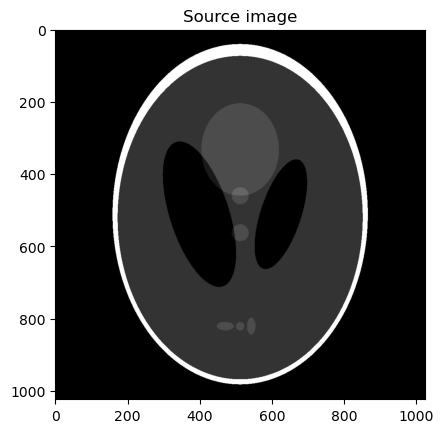

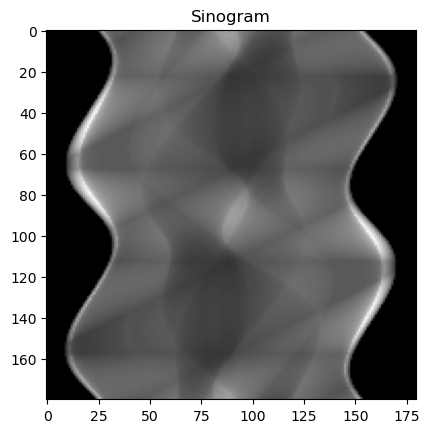

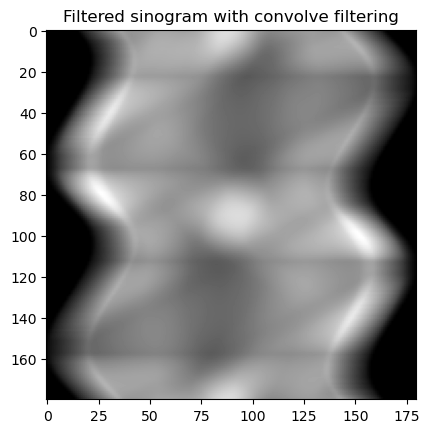

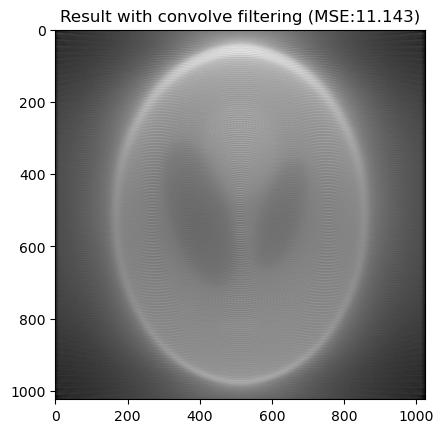

interactive(children=(IntSlider(value=10, description='n', max=180, min=1), Output()), _dom_classes=('widget-i…

interactive(children=(IntSlider(value=10, description='n', max=180, min=1), Output()), _dom_classes=('widget-i…

<function __main__.showPartialSinogram(n)>

In [ ]:
# scans 180 0.048, 270 0.050, 450 0.046, 540 0.048,720 0.046
image = load_image(imageName)
show_image(image, title='Source image')
# Radon transform
radon_image = radon_transform(image, detectors, scans, detectingAngle)
show_image(radon_image, title='Sinogram')
# Inverse radon transform
if ( not should_filter):
    inv_radon_transform = inverse_radon_transform(radon_image, image.shape, detectingAngle)
    inv_radon_transform = normalize_post_transform(inv_radon_transform)
    imMse = mean_squared_error(image, inv_radon_transform)
    show_image(inv_radon_transform, title=f'Result with no filtering (MSE:{imMse:.3f}========= )')
# Filterring
else:
    inv_radon_transform = inverse_radon_transform(radon_image, image.shape, detectingAngle)
    filtered_sinogram=filter_sinogram(radon_image)
    show_image(filtered_sinogram, title='Filtered sinogram with convolve filtering')
    filtered_image=filter_sinogram(inv_radon_transform)
    imMse = mean_squared_error(image, filtered_image)
    show_image(filtered_image, title=f'Result with convolve filtering ')
    
def show_partial_image(n):
    show_image(invRadonSteps[n-1])
def showPartialSinogram(n):
    show_image(intermediate_steps[n-1])
if (step_by):
    interact(show_partial_image, n=IntSlider(min=1,max=len(invRadonSteps),step=1,value=10))
    interact(showPartialSinogram, n=IntSlider(min=1,max=len(intermediate_steps),step=1,value=10))


## Statistic analysis
Using mean squared error the performance of the algorithm with various parameters can be measured.
1) Filtering- using filtering lowers the MSE
2) Iterations- it can be observed that by each iteration MSE drops
3) Parameters increasing accuracy:
* higher number of scans: lowers MSE linearly 
* higher number of detectors: lowers MSE linearly at first then increases 
* greater angle: lower MSE linearly

0.024519993635777015
0.023753577146585672
0.023538802689433296
0.023297693742200865
0.023389557282677328
0.023260636007328413
0.023233863820815378
0.023258979747395655
[0.024519993635777015, 0.023753577146585672, 0.023538802689433296, 0.023297693742200865, 0.023389557282677328, 0.023260636007328413, 0.023233863820815378, 0.023258979747395655]


Text(0.5, 1.0, 'MSE vs number of scans')

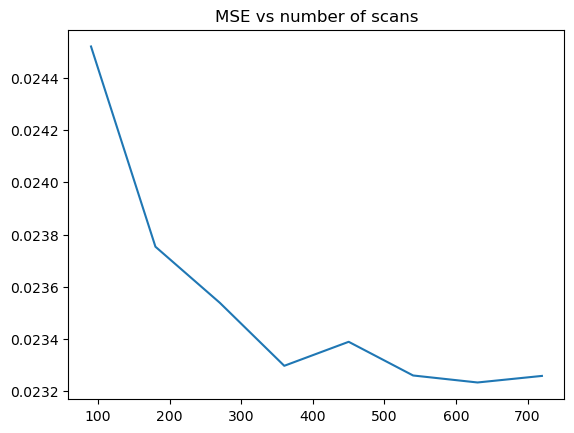

In [ ]:
experiment_image= load_image('images/CT_ScoutView.jpg')
detectors_experiment= [90,180,270,360,450,540,630,720]
scans_experiment=[90,180,270,360,450,540,630,720]   
angle_experiment=[45,90,135, 180, 225, 270]
res1=[]
for scan in scans_experiment:
    experiment_radon=radon_transform(experiment_image,num_scans=scan)
    experiment_inverse = inverse_radon_transform(experiment_radon, experiment_image.shape)
    experiment_inverse = normalize_post_transform(experiment_inverse)
    experiment_Mse = mean_squared_error(experiment_image, experiment_inverse)
    res1.append(experiment_Mse)
    print(experiment_Mse)
print(res1)

plt.plot(scans_experiment,res1)
plt.title('MSE vs number of scans')


0.027445448079183813
0.023753577146585672
0.02339128608680655
0.024965422443884867
0.03430120282720899
0.0318116593916533
0.03346657659834068
0.041623893657657014
[0.027445448079183813, 0.023753577146585672, 0.02339128608680655, 0.024965422443884867, 0.03430120282720899, 0.0318116593916533, 0.03346657659834068, 0.041623893657657014]


Text(0.5, 1.0, 'MSE vs number of detectors')

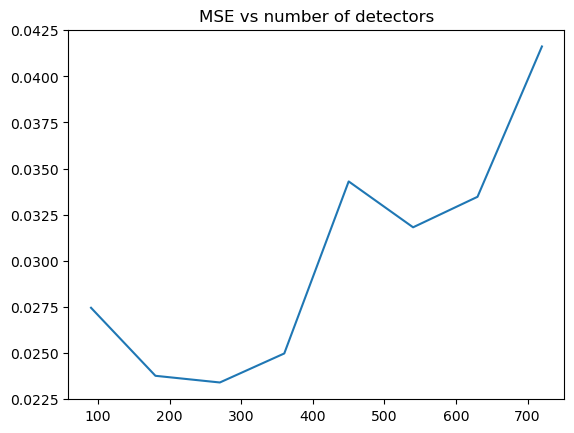

In [ ]:
experiment_image= load_image('images/CT_ScoutView.jpg')
detectors_experiment= [90,180,270,360,450,540,630,720]
scans_experiment=[90,180,270,360,450,540,630,720]   
angle_experiment=[45,90,135, 180, 225, 270]
res2=[]
for detector in detectors_experiment:
    experiment_radon=radon_transform(experiment_image,num_detectors=detector)
    experiment_inverse = inverse_radon_transform(experiment_radon, experiment_image.shape)
    experiment_inverse = normalize_post_transform(experiment_inverse)
    experiment_Mse = mean_squared_error(experiment_image, experiment_inverse)
    res2.append(experiment_Mse)
    print(experiment_Mse)
print(res2)

plt.plot(detectors_experiment,res2)
plt.title('MSE vs number of detectors')

0.06275670527027119
0.038531326763022185
0.027779139682156142
0.023753577146585672
0.0238593895680771
0.02461194360657916
[0.06275670527027119, 0.038531326763022185, 0.027779139682156142, 0.023753577146585672, 0.0238593895680771, 0.02461194360657916]


Text(0.5, 1.0, 'MSE vs angle')

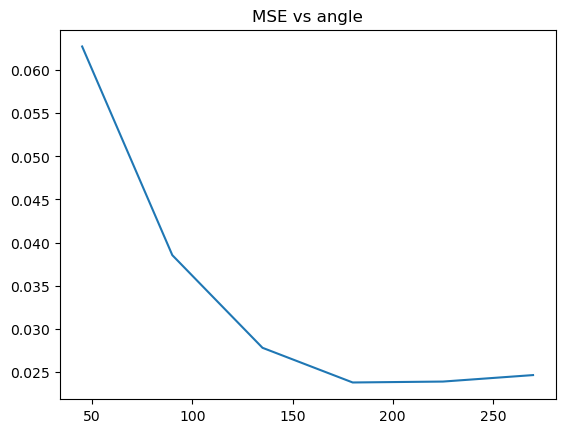

In [ ]:
experiment_image= load_image('images/CT_ScoutView.jpg')
detectors_experiment= [90,180,270,360,450,540,630,720]
scans_experiment=[90,180,270,360,450,540,630,720]   
angle_experiment=[45,90,135, 180, 225, 270]
res3=[]
for angle in angle_experiment:
    experiment_radon=radon_transform(experiment_image,fov_degrees=angle)
    experiment_inverse = inverse_radon_transform(experiment_radon, experiment_image.shape)
    experiment_inverse = normalize_post_transform(experiment_inverse)
    experiment_Mse = mean_squared_error(experiment_image, experiment_inverse)
    res3.append(experiment_Mse)
    print(experiment_Mse)
print(res3)

plt.plot(angle_experiment,res3)
plt.title('MSE vs angle')


In [ ]:
experiment_image= load_image('images/CT_ScoutView.jpg')
radom_filter=radon_transform(experiment_image)
inverse_fil=inverse_radon_transform(radom_filter,experiment_image.shape)
inverse_fil=normalize_post_transform(inverse_fil)
inverse_filter=filter_sinogram(inverse_fil)

mse1=mean_squared_error(experiment_image,inverse_fil)
mse2=mean_squared_error(experiment_image,inverse_filter)
print(mse1, ': not filtered')
print(mse2, ':filtered (looks slighlty less blurry especially the light)')

0.023753577146585672 : not filtered
0.023089935709607906 :filtered


Lastly, the image can be saved as Dicom format

In [2]:
def write_dicom(image, name, comment):
    # Use a sample as template
    filename = get_testdata_files("CT_small.dcm")[0]
    ds = pydicom.dcmread(filename)

    # Normalize to fit uint16 format
    def normalize_in_dicom(image_temp):
        image_temp = np.array(image_temp, dtype=np.float32)
        maximum = np.max(image_temp)
        if maximum != 0:
            image_temp = (image_temp * 1024 / maximum)
        return image_temp.astype(np.uint16)

    image2 = normalize_in_dicom(image)
    ds.Rows, ds.Columns = image2.shape
    ds.PixelData = image2.tobytes()

    # Set Metadata
    ds.PatientName = name
    ds.InstitutionName = 'Politechnika Poznanska'
    ds.Manufacturer = 'Politechnika Poznanska'

    now = datetime.datetime.now()
    ds.StudyDate = now.strftime('%Y%m%d')
    ds.StudyTime = now.strftime('%H%M%S.%f')[:10]
    ds.AdditionalPatientHistory = comment

    # Pixel Format for DICOM
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.BitsAllocated = 16
    ds.BitsStored = 16
    ds.HighBit = 15
    ds.PixelRepresentation = 0

    # Save
    ds.save_as("dicom_file.dcm")
    print("DICOM file saved as dicom_file.dcm")


# GUI for input
name_input = widgets.Text(description="Patient Name")
comment_input = widgets.Text(description="Comment")
upload_input = widgets.FileUpload(accept='image/*', multiple=False)
button = widgets.Button(description="Generate DICOM")
output = widgets.Output()

def on_button_click(button_instance):
    with output:
        output.clear_output()
        
        uploaded = upload_input.value

        if not uploaded:
            print("Please upload an image first!")
            return

        try:
            if isinstance(uploaded, dict):
                file_info = list(uploaded.values())[0]
                content = file_info['content']
            elif isinstance(uploaded, tuple):
                content = uploaded[0]['content']
            else:
                print("Unsupported upload format.")
                return

            image = Image.open(io.BytesIO(content)).convert('L')
            image_np = np.array(image)
            write_dicom(image_np, name_input.value, comment_input.value)

        except Exception as e:
            print(f"Error processing the file: {e}")

button.on_click(on_button_click)

display(name_input, comment_input, upload_input, button, output)


Text(value='', description='Patient Name')

Text(value='', description='Comment')

FileUpload(value=(), accept='image/*', description='Upload')

Button(description='Generate DICOM', style=ButtonStyle())

Output()